True CATE

1000 1000
(1000,)
(1000,)
3.244607490321276


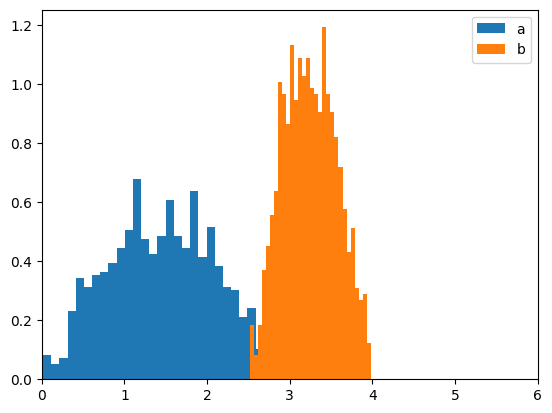

In [198]:
import numpy as np
import pandas as pd

n = 1000
k = 10
x = np.random.uniform(0,1,(n,k))
a = 1 + np.dot(x[:, 0:2], np.array([-1,2]))
b = 3 + np.dot(x[:, 2:4], np.array([1, -0.5]))
print(a.shape[0], b.shape[0])

def sigmoid(z):
    return 1/(1+np.exp(-z))

prob = sigmoid(-1-2*x[:,0]+x[:,2])
print(prob.shape)
t = np.random.binomial(1, prob, (n))
print(t.shape)
y = a + b * t + np.random.normal(0,1,n)

import matplotlib.pyplot as plt
print(np.mean(b))
plt.hist(a, bins = 30, label = 'a', density=True)
plt.hist(b, bins = 30, label = 'b', density=True)
plt.legend()
plt.xlim([0, 6.0])
plt.show()

Bivariate Regression and Bootstrap

- Bootstrap is a nonparametric method to obtain s.es and CIs for an estimator. From a sample of size $n$ we draw $B$ samples of size $n$, recompute the estimator, and find its re-sampled variance.
- Typically $B$ is a very high number e.g. 10000. If so, then as $n$ tends to infinite, the re-sampled variance tends to the true sampling variance.
- Bootstrap is valid under weaker conditions than the Jacknife. Sub-sampling is another method that is valid under weaker conditions than Bootstrap (it samples $m<n$).

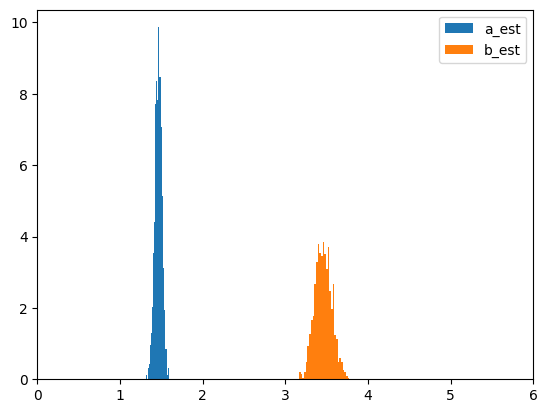

In [199]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
cols = ['y', 't'] + [f'x_{i}' for i in range(k)]
df = pd.DataFrame(np.c_[y, t, x], columns = cols)

params = []
for i in range(1000):
    res = smf.ols(formula='y ~ t', data=df.sample(n=df.shape[0], replace=True)).fit()
    params.append(list(res.params))
params = np.array(params)

plt.hist(params[:,0], bins = 30, label = 'a_est', density=True)
plt.hist(params[:,1], bins = 30, label = 'b_est', density=True)
plt.legend()
plt.xlim([0, 6.0])
plt.show()

Multivariate

In [200]:
formula = 'y ~ t + ' + " + ".join([f'x_{i}' for i in range(k)])
print(formula)
print(smf.ols(formula=formula, data=df.sample(n=df.shape[0], replace=True)).fit().summary())

y ~ t + x_0 + x_1 + x_2 + x_3 + x_4 + x_5 + x_6 + x_7 + x_8 + x_9
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     187.7
Date:                Mon, 15 Jan 2024   Prob (F-statistic):          4.32e-233
Time:                        00:08:17   Log-Likelihood:                -1431.1
No. Observations:                1000   AIC:                             2886.
Df Residuals:                     988   BIC:                             2945.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

Propensity Score

y ~ t + t:x_0 + t:x_1 + t:x_2 + t:x_3 + t:x_4 + t:x_5 + t:x_6 + t:x_7 + t:x_8 + t:x_9
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     146.3
Date:                Mon, 15 Jan 2024   Prob (F-statistic):          1.38e-198
Time:                        00:08:19   Log-Likelihood:                -1540.8
No. Observations:                1000   AIC:                             3106.
Df Residuals:                     988   BIC:                             3164.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

(array([0.18502816, 0.08223474, 0.18502816, 0.37005631, 0.45229105,
        0.55508447, 0.63731921, 1.00737552, 0.96625815, 0.86346473,
        1.13072763, 0.94569947, 1.08961026, 1.02793421, 1.08961026,
        0.98681684, 0.96625815, 0.9045821 , 1.19240368, 0.96625815,
        0.9045821 , 0.82234737, 0.71955394, 0.57564316, 0.43173237,
        0.5139671 , 0.30838026, 0.26726289, 0.28782158, 0.1233521 ]),
 array([2.51988849, 2.56852973, 2.61717098, 2.66581222, 2.71445347,
        2.76309471, 2.81173596, 2.8603772 , 2.90901845, 2.9576597 ,
        3.00630094, 3.05494219, 3.10358343, 3.15222468, 3.20086592,
        3.24950717, 3.29814841, 3.34678966, 3.3954309 , 3.44407215,
        3.49271339, 3.54135464, 3.58999589, 3.63863713, 3.68727838,
        3.73591962, 3.78456087, 3.83320211, 3.88184336, 3.9304846 ,
        3.97912585]),
 <BarContainer object of 30 artists>)

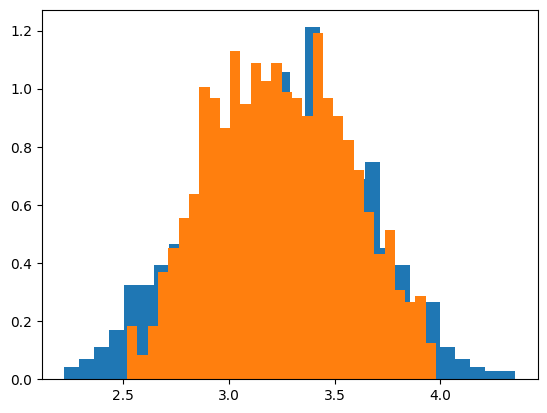

In [201]:
params = []
k = 10  # Replace with the actual number of x_i columns you have
formula = 'y ~ t'
for i in range(k):
    formula += " + t:x_{}".format(i)
print(formula)
model1 = smf.ols(formula=formula, data=df.sample(n=df.shape[0], replace=True))
res = model1.fit()
print(res.summary())

# Function to add interaction terms for predictions
def add_interaction_terms(df, t_value):
    df_modified = df.copy()
    df_modified['t'] = t_value
    for i in range(k):  # Adding interaction terms
        df_modified[f't:x_{i}'] = df_modified['t'] * df_modified[f'x_{i}']
    return df_modified

# Create df1 and df0 with the interaction terms
df1 = add_interaction_terms(df, 1)
df0 = add_interaction_terms(df, 0)

# Predict Y1 and Y0 using the fitted model
yhat1 = res.predict(df1)
yhat0 = res.predict(df0)
b_est = yhat1 - yhat0
plt.hist(tau, bins = 30, label = 'b_est', density=True)
plt.hist(b, bins = 30, label = 'b', density=True)

y ~ t +x_0 + x_1 + x_2 + x_3 + x_4 + x_5 + x_6 + x_7 + x_8 + x_9 + t:x_0 + t:x_1 + t:x_2 + t:x_3 + t:x_4 + t:x_5 + t:x_6 + t:x_7 + t:x_8 + t:x_9
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     104.4
Date:                Mon, 15 Jan 2024   Prob (F-statistic):          1.57e-232
Time:                        00:08:19   Log-Likelihood:                -1397.4
No. Observations:                1000   AIC:                             2839.
Df Residuals:                     978   BIC:                             2947.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.02

(array([0.18502816, 0.08223474, 0.18502816, 0.37005631, 0.45229105,
        0.55508447, 0.63731921, 1.00737552, 0.96625815, 0.86346473,
        1.13072763, 0.94569947, 1.08961026, 1.02793421, 1.08961026,
        0.98681684, 0.96625815, 0.9045821 , 1.19240368, 0.96625815,
        0.9045821 , 0.82234737, 0.71955394, 0.57564316, 0.43173237,
        0.5139671 , 0.30838026, 0.26726289, 0.28782158, 0.1233521 ]),
 array([2.51988849, 2.56852973, 2.61717098, 2.66581222, 2.71445347,
        2.76309471, 2.81173596, 2.8603772 , 2.90901845, 2.9576597 ,
        3.00630094, 3.05494219, 3.10358343, 3.15222468, 3.20086592,
        3.24950717, 3.29814841, 3.34678966, 3.3954309 , 3.44407215,
        3.49271339, 3.54135464, 3.58999589, 3.63863713, 3.68727838,
        3.73591962, 3.78456087, 3.83320211, 3.88184336, 3.9304846 ,
        3.97912585]),
 <BarContainer object of 30 artists>)

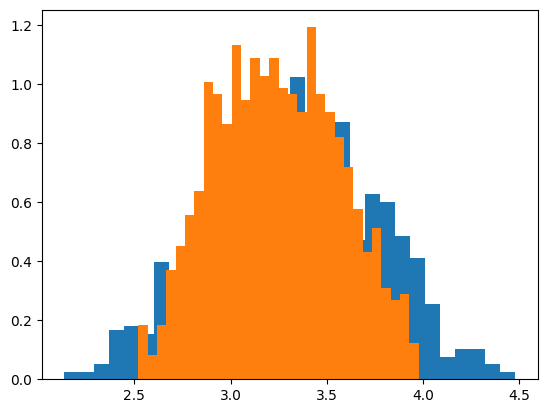

In [202]:
import pandas as pd
import statsmodels.formula.api as smf

# Your existing code for model building
params = []
k = 10  # Replace with the actual number of x_i columns you have
formula = 'y ~ t +' + " + ".join([f'x_{i}' for i in range(k)])
for i in range(k):
    formula += " + t:x_{}".format(i)
print(formula)
model1 = smf.ols(formula=formula, data=df.sample(n=df.shape[0], replace=True))
res = model1.fit()
print(res.summary())

# Function to add interaction terms for predictions
def add_interaction_terms(df, t_value):
    df_modified = df.copy()
    df_modified['t'] = t_value
    for i in range(k):  # Adding interaction terms
        df_modified[f't:x_{i}'] = df_modified['t'] * df_modified[f'x_{i}']
    return df_modified

# Create df1 and df0 with the interaction terms
df1 = add_interaction_terms(df, 1)
df0 = add_interaction_terms(df, 0)

# Predict Y1 and Y0 using the fitted OLS model
yhat1 = res.predict(df1)
yhat0 = res.predict(df0)
b_est = yhat1 - yhat0
plt.hist(b_est, bins = 30, label = 'b_est', density=True)
plt.hist(b, bins = 30, label = 'b', density=True)

Doubly Robust Estimator

t ~ x_0 + x_1 + x_2 + x_3 + x_4 + x_5 + x_6 + x_7 + x_8 + x_9


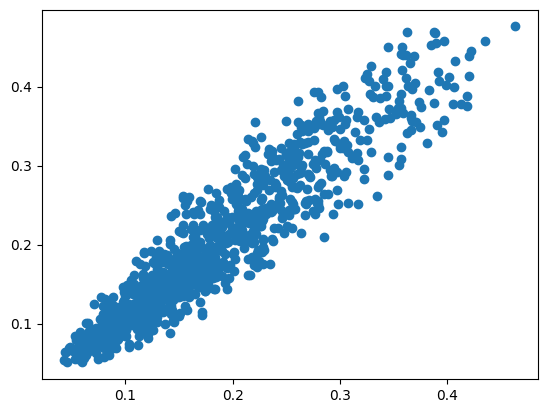

3.359475502931579 12.734872779897948


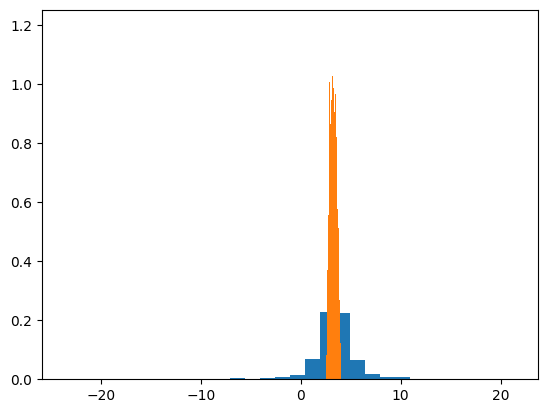

DR Tau: 3.3790128562942217
Standard Error of DR Tau: 0.0908896666106801


In [203]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Your existing GLM model code
k = 10  # replace with the actual number of x_i columns you have
formula = 't ~ ' + " + ".join([f'x_{i}' for i in range(k)])
print(formula)
model2 = smf.glm(formula=formula, data=df, family=sm.families.Binomial())
gres = model2.fit()
prob_est = model2.predict(gres.params)

# Scatter plot
plt.scatter(prob_est, prob)  # Ensure 'prob' is defined in your context
plt.show()

# Transformed Outcomes
ty = y * ((t - prob_est) / (prob_est * (1 - prob_est)))
print(np.mean(ty), np.sqrt(np.var(ty)))

# Doubly Robust Estimator calculations
# yhat1, yhat0 come from regression adjustment
# prob_est is the propensity score
dr_cate = (yhat1 + t * (y - yhat1) / prob_est) - (yhat0 + (1 - t) * (y - yhat0) / (1 - prob_est))
dr_tau = np.mean(dr_cate)
std_error_dr_tau = np.sqrt(np.var(dr_cate) / n)

# plot
plt.hist(dr_cate, bins = 30, label = 'b_est', density=True)
plt.hist(b, bins = 30, label = 'b', density=True)
plt.show()

# Display results
print("DR Tau:", dr_tau)
print("Standard Error of DR Tau:", std_error_dr_tau)


Counterfactual

In [204]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

# (Counterfactual) Policy Evaluation
cost = 1

# Policy
t_star = (tau > cost).astype(int)
t_true = (b > cost).astype(int)

# Creating a contingency table
contingency_table = pd.crosstab(t_star, t_true)
print(contingency_table)

# Profit calculation for trt_star
df['trt'] = t_star
model1 = smf.ols(formula="y ~ trt", data=df)  # Assuming 'y' is your outcome variable
res = model1.fit()
prft_star = sum(res.predict(df) - cost * t_star)
print("Profit for trt_star:", prft_star)

# Profit calculation for trt_tru
df['trt'] = t_true
model2 = smf.ols(formula="y ~ trt", data=df)
res2 = model2.fit()
prft_true = sum(res2.predict(df) - cost * t_true)
print("Profit for trt_tru:", prft_true)

# Counterfactual Profits
counterfactual_profit_star = sum((t_star * t / prob_est) * (y - cost) + ((1 - t_star) * (1 - t) / (1 - prob_est)) * y)
counterfactual_profit_tru = sum((t_true * t / prob_est) * (y - cost) + ((1 - t_star) * (1 - t) / (1 - prob_est)) * y)

print("Counterfactual Profit for trt_star:", counterfactual_profit_star)
print("Counterfactual Profit for trt_tru:", counterfactual_profit_tru)

col_0     1
row_0      
1      1000
Profit for trt_star: 1111.328125
Profit for trt_tru: 1111.328125
Counterfactual Profit for trt_star: 3839.939630393393
Counterfactual Profit for trt_tru: 3839.939630393393
